Train set missing values:
주거 형태                0
연간 소득                0
현재 직장 근속 연수          0
체납 세금 압류 횟수          0
개설된 신용계좌 수           0
신용 거래 연수             0
최대 신용한도              0
신용 문제 발생 횟수          0
마지막 연체 이후 경과 개월 수    0
개인 파산 횟수             0
대출 목적                0
대출 상환 기간             0
현재 대출 잔액             0
현재 미상환 신용액           0
월 상환 부채액             0
신용 점수                0
채무 불이행 여부            0
dtype: int64

Test set missing values:
주거 형태                0
연간 소득                0
현재 직장 근속 연수          0
체납 세금 압류 횟수          0
개설된 신용계좌 수           0
신용 거래 연수             0
최대 신용한도              0
신용 문제 발생 횟수          0
마지막 연체 이후 경과 개월 수    0
개인 파산 횟수             0
대출 목적                0
대출 상환 기간             0
현재 대출 잔액             0
현재 미상환 신용액           0
월 상환 부채액             0
신용 점수                0
dtype: int64
Training fold 1/5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2730, number of negative: 5

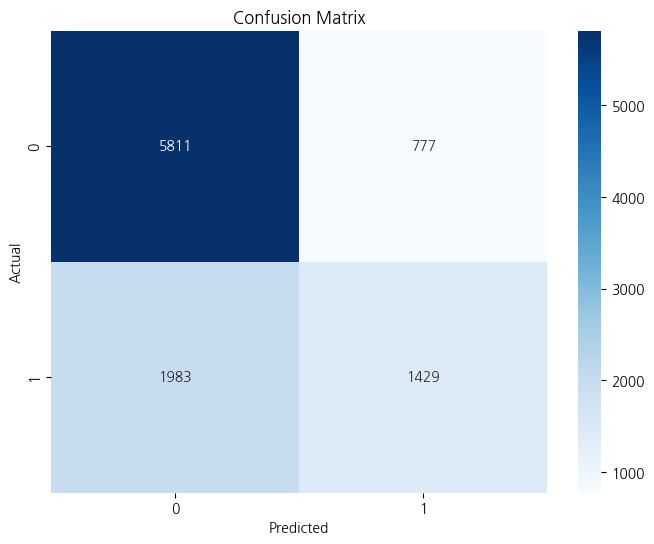

Submission file has been created successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = font_manager.FontProperties(fname=font_path)
rc('font', family=fontprop.get_name())

# 1. 데이터 로드
train = pd.read_csv('/apps/study_promptengineerings/dacon/debt_risk/train.csv')
test = pd.read_csv('/apps/study_promptengineerings/dacon/debt_risk/test.csv')

# ID 매핑 저장 및 컬럼 제거
id_mapping = pd.Series(test['UID'].values, index=test.index)
train = train.drop('UID', axis=1)
test = test.drop('UID', axis=1)

# 2. 결측치 확인
print("Train set missing values:")
print(train.isnull().sum())
print("\nTest set missing values:")
print(test.isnull().sum())

# 3. 범주형 변수 지정
cat_features = ['주거 형태', '대출 목적', '대출 상환 기간', '현재 직장 근속 연수']

# 4. 데이터 준비
X = train.drop('채무 불이행 여부', axis=1)
y = train['채무 불이행 여부']

# 범주형 변수 인코딩
X = pd.get_dummies(X, columns=cat_features)
test = pd.get_dummies(test, columns=cat_features)

# 5. 모델 정의
# 최적화된 LightGBM 모델
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,       # 최적 n_estimators 값
    learning_rate=0.05,     # 최적 learning_rate 값
    max_depth=7,            # 최적 max_depth 값
    num_leaves=31,          # 최적 num_leaves 값
    min_child_samples=20,   # 최적 min_child_samples 값
    random_state=42
)

# 최적화된 XGBoost 모델
xgb_model = xgb.XGBClassifier(
    n_estimators=200,       # 최적 n_estimators 값
    learning_rate=0.05,     # 최적 learning_rate 값
    max_depth=5,            # 최적 max_depth 값
    subsample=0.8,          # 최적 subsample 값
    colsample_bytree=0.8,   # 최적 colsample_bytree 값
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 최적화된 RandomForest 모델
rf_model = RandomForestClassifier(
    n_estimators=200,       # 최적 n_estimators 값
    max_depth=20,           # 최적 max_depth 값
    min_samples_split=5,    # 최적 min_samples_split 값
    min_samples_leaf=2,     # 최적 min_samples_leaf 값
    bootstrap=True,         # 최적 bootstrap 값
    random_state=42
)

# 스태킹 앙상블 정의
stacking_model = StackingClassifier(
    estimators=[
        ('lgb', lgb_model),
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# 6. 교차 검증 및 모델 학습
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Training fold {fold + 1}/5")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 모델 학습
    stacking_model.fit(X_train, y_train)
    
    # OOF 예측 및 테스트 데이터 예측
    oof_preds[val_idx] = stacking_model.predict(X_val)
    test_preds += stacking_model.predict(test) / skf.n_splits

# 7. 모델 평가
f1 = f1_score(y, oof_preds, average='macro')
print(f"\nOOF F1 Score: {f1:.4f}")

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, oof_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 8. 제출 파일 생성
submission = pd.DataFrame({
    'UID': id_mapping,
    '채무 불이행 확률': (test_preds > 0.5).astype(int)
})
submission.to_csv('submission.csv', index=False)
print("Submission file has been created successfully!")
